In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
all_data = pd.read_csv("all_merged_data.csv")

In [ ]:
all_data['time'] = pd.to_datetime(all_data['time'])
all_data['year'] = all_data['time'].dt.year

all_data.head()

,time,local_time,t2m,prectotland,precsnoland,snomas,rhoa,swgdn,swtdn,cldtot,wind_speed,quarter,month,month_name,day,hour,year
0,2015-01-01 00:00:00,2015-01-01 00:00,7.742,0.023,0.0,0.017,1.259,0.0,0.0,0.994,8.747,1,1,January,1,0,2015
1,2015-01-01 01:00:00,2015-01-01 01:00,7.768,0.029,0.0,0.016,1.259,0.0,0.0,0.973,8.576,1,1,January,1,1,2015
2,2015-01-01 02:00:00,2015-01-01 02:00,7.974,0.035,0.0,0.015,1.257,0.0,0.0,0.936,9.216,1,1,January,1,2,2015
3,2015-01-01 03:00:00,2015-01-01 03:00,8.486,0.052,0.0,0.013,1.255,0.0,0.0,0.928,9.385,1,1,January,1,3,2015
4,2015-01-01 04:00:00,2015-01-01 04:00,8.867,0.050,0.0,0.012,1.253,0.0,0.0,0.988,9.575,1,1,January,1,4,2015


In [ ]:
def split_data(X, y, train_ratio=0.8):
    """
    Splits the input and output sequences into training and testing sets.

    Parameters:
        X (np.ndarray): Input sequences.
        y (np.ndarray): Corresponding target values.
        train_ratio (float): Fraction of data to be used for training.

    Returns:
        X_train, X_test, y_train, y_test: Split datasets.
    """
    split_point = int(len(X) * train_ratio)
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    return X_train, X_test, y_train, y_test


In [ ]:
import numpy as np

def encode_time_features(df):
    df = df.copy()

    # Cyclical Encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

    # Drop original time-related categorical features
    df.drop(columns=['hour', 'month', 'day', 'quarter', 'month_name', 'year'], errors='ignore', inplace=True)

    return df

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def prepare_multivariate_timeseries_data(
    df, input_hours=24, forecast_horizon=2, target_col="swgdn"
):
    df = df.copy()

    drop_cols = ['swtdn', 'year', 'month_name', 'time', 'local_time']
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

    static_features = [col for col in df.columns if col != target_col]
    feature_names = []

    # Separate target and features
    target_vals = df[[target_col]].values
    feature_vals = df[static_features].values

    # Scale separately
    y_scaler = MinMaxScaler()
    X_scaler = MinMaxScaler()

    target_scaled = y_scaler.fit_transform(target_vals).flatten()
    features_scaled = X_scaler.fit_transform(feature_vals)

    X, y = [], []

    for i in range(len(df) - input_hours - forecast_horizon + 1):
        lag_seq = target_scaled[i : i + input_hours]

        future_idx = i + input_hours + forecast_horizon - 1
        static_feat = features_scaled[future_idx]

        X.append(np.concatenate([lag_seq, static_feat]))
        y.append(target_scaled[future_idx])  # predict target value

    feature_names = [f"{target_col}_lag_{i+1}" for i in range(input_hours)] + static_features

    return np.array(X), np.array(y), X_scaler, y_scaler, feature_names

In [ ]:
df = all_data.copy()

df_encoded = encode_time_features(df)

X_seq, y_seq, X_scaler, y_scaler, feature_names  = prepare_multivariate_timeseries_data(
    df_encoded, input_hours=24, forecast_horizon=2
)

X_train, X_test, y_train, y_test = split_data(X_seq, y_seq)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")
print(f"Input features: {feature_names}")


Train shape: (70117, 39), (70117,)
Test shape: (17530, 39), (17530,)
Input features: ['swgdn_lag_1', 'swgdn_lag_2', 'swgdn_lag_3', 'swgdn_lag_4', 'swgdn_lag_5', 'swgdn_lag_6', 'swgdn_lag_7', 'swgdn_lag_8', 'swgdn_lag_9', 'swgdn_lag_10', 'swgdn_lag_11', 'swgdn_lag_12', 'swgdn_lag_13', 'swgdn_lag_14', 'swgdn_lag_15', 'swgdn_lag_16', 'swgdn_lag_17', 'swgdn_lag_18', 'swgdn_lag_19', 'swgdn_lag_20', 'swgdn_lag_21', 'swgdn_lag_22', 'swgdn_lag_23', 'swgdn_lag_24', 't2m', 'prectotland', 'precsnoland', 'snomas', 'rhoa', 'cldtot', 'wind_speed', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos']


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# Define and train the model
Best_Parameters = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
model = XGBRegressor(**Best_Parameters, random_state=42)
model.fit(X_train, y_train)

# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluation
def evaluate(y_true, y_pred, label=''):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} MAE: {mae:.4f}")
    print(f"{label} R²: {r2:.4f}")
    print(f"{label} RMSE: {rmse:.4f}")
    print("-" * 30)

evaluate(y_train, y_train_pred, label='Train')
evaluate(y_test, y_test_pred, label='Test')


Train MAE: 0.0113
Train R²: 0.9908
Train RMSE: 0.0231
------------------------------
Test MAE: 0.0152
Test R²: 0.9816
Test RMSE: 0.0324
------------------------------


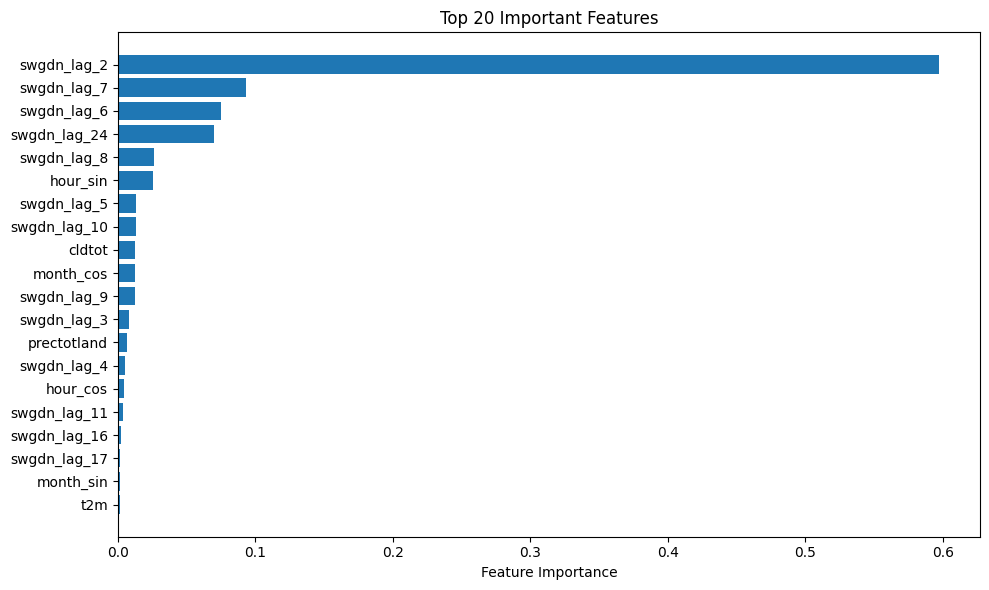

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
features = X_train.columns if hasattr(X_train, 'columns') else feature_names  # fallback to input_features list
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 20 features
top_N = 20
top_features = feature_importance_df.head(top_N)['feature'].tolist()

plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], feature_importance_df.head(top_N)['importance'][::-1])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_N} Important Features")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler  # or StandardScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

top_ns = list(range(5, len(feature_importance_df) + 1, 3))
errors = []

for N in tqdm(top_ns):
    # Select top N features
    top_features_N = feature_importance_df.head(N)['feature'].tolist()

    # Subset raw X
    X_train_N_raw = pd.DataFrame(X_train, columns=features)[top_features_N]
    X_test_N_raw = pd.DataFrame(X_test, columns=features)[top_features_N]

    # Scale X subset
    X_scaler_N = MinMaxScaler()
    X_train_N_scaled = X_scaler_N.fit_transform(X_train_N_raw)
    X_test_N_scaled = X_scaler_N.transform(X_test_N_raw)

    # Fit model
    model_N = XGBRegressor(**Best_Parameters, random_state=42)
    model_N.fit(X_train_N_scaled, y_train)

    # Predict and inverse-scale y
    y_test_pred_scaled = model_N.predict(X_test_N_scaled).reshape(-1, 1)
    y_test_pred_orig = y_scaler.inverse_transform(y_test_pred_scaled)
    y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1))

    # Compute MAE in original scale
    mae = mean_absolute_error(y_test_orig, y_test_pred_orig)
    errors.append(mae)


100%|██████████| 12/12 [00:31<00:00,  2.62s/it]


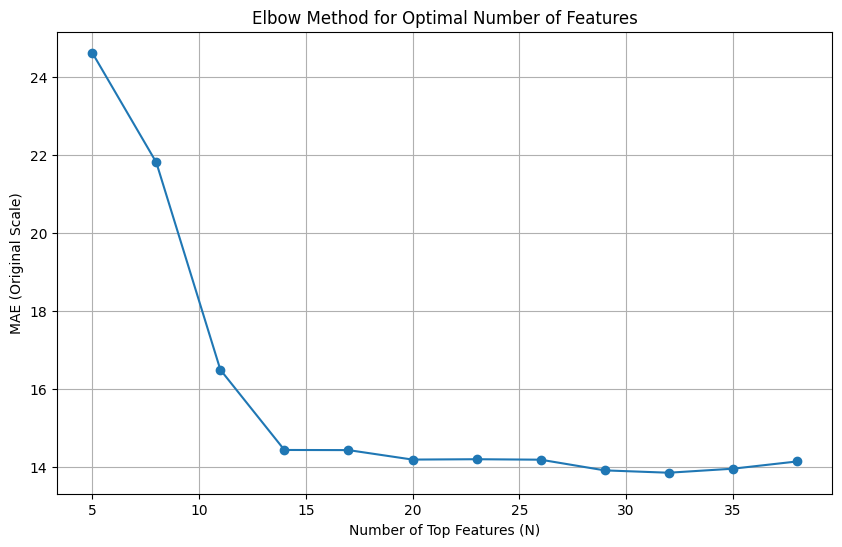

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(top_ns, errors, marker='o')
plt.xlabel('Number of Top Features (N)')
plt.ylabel('MAE (Original Scale)')
plt.title('Elbow Method for Optimal Number of Features')
plt.grid(True)
plt.show()


In [ ]:
optimal_N = top_ns[np.argmin(errors)]
print(f"Optimal N = {optimal_N} with lowest MAE = {min(errors):.4f}")


Optimal N = 32 with lowest MAE = 13.8513


In [ ]:
top_N = 32
top_features = feature_importance_df.head(top_N)['feature'].tolist()

# Subset data with top N features
X_train_top = pd.DataFrame(X_train, columns=features)[top_features]
X_test_top = pd.DataFrame(X_test, columns=features)[top_features]

# Retrain model on top N features
model_top = XGBRegressor(**Best_Parameters, random_state=42)
model_top.fit(X_train_top, y_train)

# Predict again
y_train_pred_top = model_top.predict(X_train_top)
y_test_pred_top = model_top.predict(X_test_top)

# Evaluation
evaluate(y_train, y_train_pred_top, label=f'Train (Top {top_N})')
evaluate(y_test, y_test_pred_top, label=f'Test (Top {top_N})')


Train (Top 32) MAE: 0.0116
Train (Top 32) R²: 0.9901
Train (Top 32) RMSE: 0.0239
------------------------------
Test (Top 32) MAE: 0.0149
Test (Top 32) R²: 0.9822
Test (Top 32) RMSE: 0.0319
------------------------------


## PCA

In [ ]:
df = all_data.copy()
df = df.dropna()

df_encoded = encode_time_features(df)

X_seq, y_seq, X_scaler, y_scaler, feature_names  = prepare_multivariate_timeseries_data(
    df_encoded, input_hours=24, forecast_horizon=2
)

X_train, X_test, y_train, y_test = split_data(X_seq, y_seq)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")
print(f"Input features: {feature_names}")


Train shape: (70116, 39), (70116,)
Test shape: (17530, 39), (17530,)
Input features: ['swgdn_lag_1', 'swgdn_lag_2', 'swgdn_lag_3', 'swgdn_lag_4', 'swgdn_lag_5', 'swgdn_lag_6', 'swgdn_lag_7', 'swgdn_lag_8', 'swgdn_lag_9', 'swgdn_lag_10', 'swgdn_lag_11', 'swgdn_lag_12', 'swgdn_lag_13', 'swgdn_lag_14', 'swgdn_lag_15', 'swgdn_lag_16', 'swgdn_lag_17', 'swgdn_lag_18', 'swgdn_lag_19', 'swgdn_lag_20', 'swgdn_lag_21', 'swgdn_lag_22', 'swgdn_lag_23', 'swgdn_lag_24', 't2m', 'prectotland', 'precsnoland', 'snomas', 'rhoa', 'cldtot', 'wind_speed', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos']


In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaler_pca = StandardScaler()
X_train_scaled = X_scaler_pca.fit_transform(X_train)
X_test_scaled = X_scaler_pca.transform(X_test)


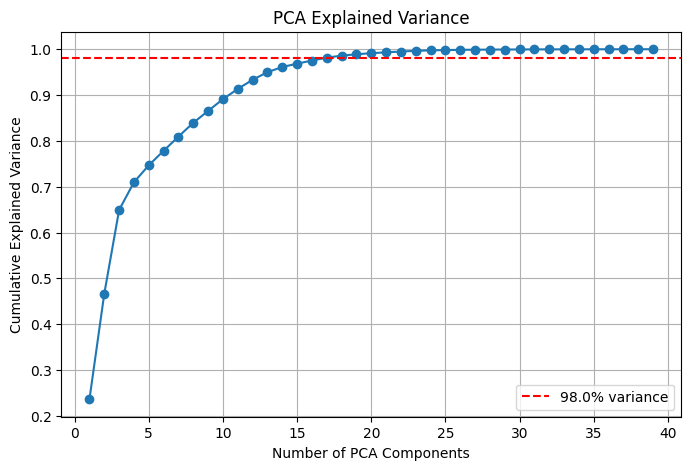

Selected 17 PCA components (≥98.0% variance)


In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(X_train_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

vad = 0.98

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.axhline(y=vad, color='r', linestyle='--', label=f'{vad*100}% variance')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.legend()
plt.show()

# Pick number of components for 95% variance
n_components = np.argmax(explained_variance >= vad) + 1
print(f"Selected {n_components} PCA components (≥{vad*100}% variance)")


In [ ]:
pca_final = PCA(n_components=n_components)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)


In [ ]:
X_train_pca.shape

(70116, 17)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model_pca = XGBRegressor(**Best_Parameters, random_state=42)
model_pca.fit(X_train_pca, y_train)

# Predict and inverse-transform
y_test_pred_scaled = model_pca.predict(X_test_pca).reshape(-1, 1)
y_test_pred_orig = y_scaler.inverse_transform(y_test_pred_scaled)
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
mae = mean_absolute_error(y_test_orig, y_test_pred_orig)
r2 = r2_score(y_test_orig, y_test_pred_orig)

print(f"PCA-Based XGBoost Performance:")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


PCA-Based XGBoost Performance:
MAE: 21.9560
R²: 0.9660


In [ ]:
# PCA is not good here